# pyCTF

pyCTF package allows to measure lens aberrations from experimental contrast transfer functions

First, import the package:

In [1]:
import pyCTF
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

invoking __init__.py for pyCTF


## Simulating contrast transfer functions

### 1D CTF simulation

equations and stuff here

In [ ]:
## 1D CTF simulation
from pyCTF.simulation import CTFSimulation1D
CTF = CTFSimulation1D( 5.0, int(2000), 200, -251.5 )
CTF.Cs = 1.68e-3
CTF.update()
CTF.plot_ctf()
CTF.show_all()
CTF.print_aberrations()

### 2D CTF simulation

The same process can be used to simulate a CTF in 2D:

In [ ]:
### 2D CTF simulation ###
from pyCTF.simulation import CTFSimulation2D
CTF2D = CTFSimulation2D( 5, int(256), 200, -300)
CTF2D.C12a = 50e-9
CTF2D.C12b = 20e-9
CTF2D.phi = np.deg2rad(110)
CTF2D.update()
CTF2D.print_aberrations()
CTF2D.plot_ctf()
CTF2D.show_all()

## Measuring lens aberrations

### Chromatic aberration

Chromatic aberration ($C_c$) can be measured using the following relationship (Klemperer, 1971): 

$ \Delta F = C_c ( \frac{\Delta V}{ V} -  \frac{2*\Delta I}{ I }  )$

Where $I$ is the objective lens current, $V$ is the accelerating voltage, $\Delta V$ is the voltage instability, and $\Delta F$ is the change in lens focal length. Assuming the objective lens current instability ($\Delta I$) is negligable, measuring the change in defocus as a function of the accelerating voltage gives the chromatic aberration of the objective lens via (McMullan et al, 2023):

$ \Delta F = C_c \Delta V$

We can do this with a linear fit. First, declare the defocus and their accelerating voltages:

In [ ]:
voltage = 200
voltage_data = np.array([200.0, 199.95, 199.90, 199.85, 199.80, 199.75, 199.70])
defocus_data =   np.array([ -714.09, -433.04, -197.66, 0, 240.20, 458.89, 688.94 ])*1e-9

Then, fit the data:

In [ ]:
## chromatic aberration functions
from pyCTF.chromatic_aberration import chromaticAberration
Cc = chromaticAberration( voltage, voltage_data, defocus_data)
fit_method = 'lmfit'
Cc.fit( method=fit_method )
Cc.plot_figure( method=fit_method )
Cc.print_results( method=fit_method )
plt.show()

### Measuring spherical aberration

In [ ]:
## CTF zeros measurement test ##
from pyCTF.CTF_image import CTFImage
CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\FEG_CTF.tif' )), 
											200, 
											0.0066127 )
CTF.remove_background( 8, 4 )
CTF.process_CTF_profile( f_limits=[0.1,0.68], polynomial=10, window=3 )
CTF.measure_defocus( xlim=[0.1, 0.7], ylim=[0.0, 0.5], flim=[0.0, 0.7] )
CTF.print_Cs_results()

### Measuring objective lens twofold astigmatism

Even when corrected by the operator, small amounts of twofold astigmatism in the objective lens are common.

[33.83333333]
100.0, 80.0


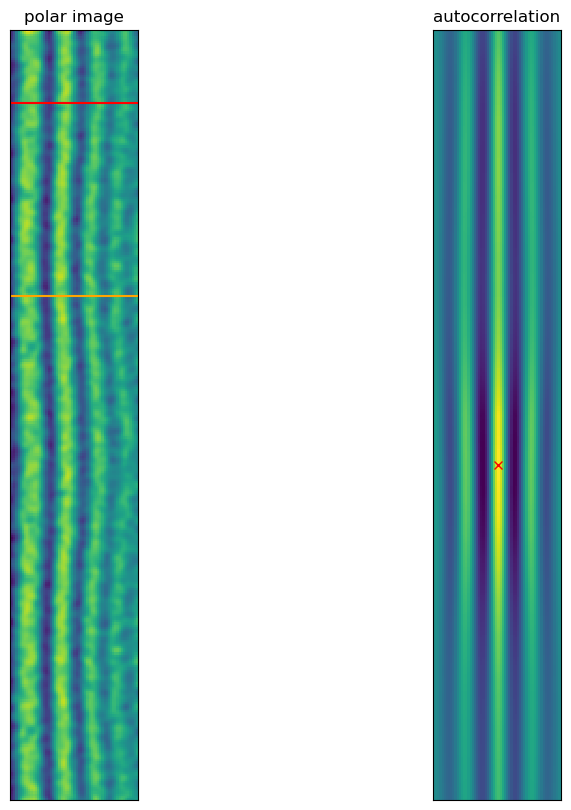

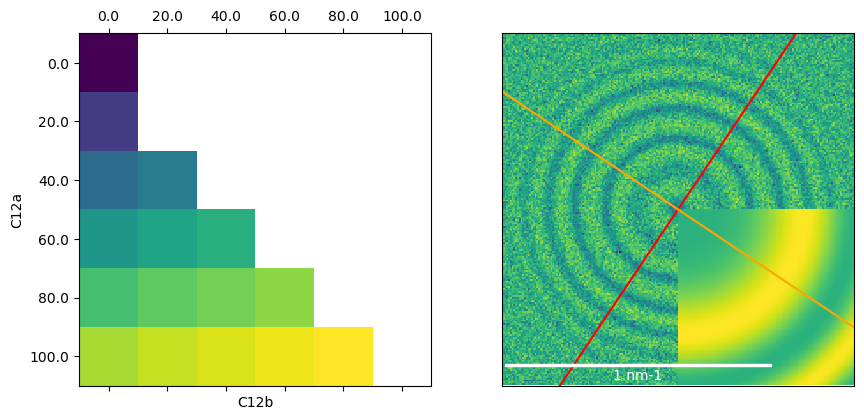

In [2]:
## astigmatism measurement ##
CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'img\\FEG_CTF.tif' )), 200, 0.0066127 )
CTF.remove_background(10, 10)
CTF.astig_angle() # add kwargs to crop frequency range for this op
CTF.astig.plot_angles()
print( CTF.astig.amax )
CTF.astig_magnitude( -1000, slices=6, max_val=100 )

## Manipulating Fourier transforms

### 2D Fourier transform of CTF

In [ ]:
## examples of Fourier class 2D
from pyCTF.fourier import Fourier

stack = Fourier.import_stack( 'assets//UTC_TF_stack.tif' )
# process 2D FFT
FFT = Fourier.fft_stack( stack )
FFT = Fourier.log_mod( FFT )
FFT = Fourier.crop( FFT, width=300 )
FFT = Fourier.remove_bckg_stack( FFT, 8, 8 )
Fourier.show_fft( np.sum( FFT[:, :, :], 0 ) )

### 3D Fourier transform of CTF

In [ ]:
## examples of Fourier class 3D
from pyCTF.fourier import Fourier

stack = Fourier.import_stack( 'assets//UTC_TF_stack.tif' )
FFT, prof = Fourier.through_focus( stack, width=350 )
#plt.matshow( FFT[:, :, 0] )
FFT3D = Fourier.fft3d( stack )
FFT3D = np.log(np.abs(FFT3D))
img = np.rot90( FFT3D, k=1, axes=(0, 2) )
img = np.sum( img[:,:,:], 2 )
output, filtered = Fourier.measure_arcs( img, 4 )
Fourier.plot_arcs( filtered, output )